<a href="https://colab.research.google.com/github/ivanadj3/MIEP/blob/main/BreastCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija skupa podataka tumora dojke

**Mašinsko učenje** (ML) može biti efikasno korišćeno za analizu i klasifikaciju skupova podataka o raku dojke, pružajući dragocene uvide i pomažući u ranom otkrivanju i planiranju lečenja.

Skupovi podataka o raku dojke obično sadrže karakteristike koje opisuju osobine ćelijskih jezgara prisutnih u biopsijama raka dojke. U ovom projektu radili smo sa dijagnostičkim skupom podataka pod nazivom Breast Cancer Wisconsin.
Ovaj skup podataka ima 569 primera sa 30 karakteristika kao što su srednji poluprečnik, srednja tekstura, srednji obim, srednja površina, itd.

Ovaj skup podataka obezbedila je bolnica University of Wisconsin, Madison, i Dr. William H. Wolberg. Ciljna promenljiva je binarna oznaka koja ukazuje na to da li je tumor **maligni** (kancerogeni) ili **benigni** (nekancerogeni).

**Karakteristike** su izračunate za svako ćelijsko jezgro i uključuju:

1.   Poluprečnik: Srednja vrednost udaljenosti od centra do tačaka na obodu.
2.   Tekstura: Standardna devijacija sivih tonova.
3.   Perimetar: Perimetar ćelijskog jezgra.
4.   Površina: Površina ćelijskog jezgra.
5.   Glatkost: Lokalna varijacija dužine poluprečnika.
6.   Kompaktnost
7.   Konakavost: Ozbiljnost konkavnih delova konture.
8.   Konkavne Tačke: Broj konkavnih delova konture.
9.   Simetrija: Simetrija ćelijskog jezgra.
10.   Fraktalna dimenzija


Svaka od ovih karakteristika je izračunata na tri načina:


*   Srednja vrednost: Prosečna vrednost karakteristike
*   Standardna greška: Standardna greška karakteristike
*   Najgore: Najveća srednja vrednost karakteristike na slici


Prvi korak jeste implementacija podataka koje smo prethodno uploadovali koristeći Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Zatim sledi instalacija svih potrebnih biblioteka.

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_path = '/content/drive/MyDrive/BreastCancerDataset/data.csv'
df = pd.read_csv(data_path)

U narednom delu postavićemo početno stanje za generator slučajnih brojeva u NumPy biblioteci. To osigurava da svi slučajni brojevi generisani u kodu budu isti svaki put kada se pokrene, što je korisno za reproduktivnost rezultata.

Zatim dodajemo novu kolonu density u DataFrame df. Vrednosti u ovoj koloni su slučajno izabrane između 'A', 'B', 'C' i 'D' za svaki red u DataFrame-u. Te vrednosti ćemo zameniti kao: 'A' sa 0, 'B' sa 1, 'C' sa 2 i 'D' sa 3.

To je korisno jer mnogi algoritmi mašinskog učenja bolje funkcionišu sa numeričkim podacima nego sa kategorijskim.

In [ ]:
np.random.seed(42)

df['density'] = np.random.choice(['A', 'B', 'C', 'D'], size=len(df))

density_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df['density'] = df['density'].map(density_mapping)

df = df.drop(columns=['id', 'Unnamed: 32']) #Ova linija uklanja kolone id i Unnamed: 32 iz DataFrame-a df, jer te kolone verovatno nisu relevantne za analizu ili modeliranje

X = df.drop(columns=['diagnosis']).values #X: Sadrži sve kolone osim kolone diagnosis i koristi se kao ulazne karakteristike za model
y = df['density'].values #y: Sadrži kolonu density i koristi se kao ciljne vrednosti

scaler = StandardScaler()
X = scaler.fit_transform(X) #Linije koje standardizuju karakteristike u X tako da imaju srednju vrednost 0 i standardnu devijaciju


#  X_train i y_train su ulazne karakteristike i ciljne vrednosti za trening skup
#  X_test i y_test su ulazne karakteristike i ciljne vrednosti za test skup
#  test_size=0.2 znači da će 20% podataka biti u test skupu, dok će 80% biti u trening skupu
#  random_state=42 osigurava reproduktivnost podele
#  stratify=y osigurava da proporcije ciljne promenljive budu iste u oba skupa

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ispis oblika podataka

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (455, 31)
X_test shape: (114, 31)
y_train shape: (455,)
y_test shape: (114,)


Definišemo klasu BreastCancerDataset koja nasleđuje klasu Dataset iz biblioteke torch.utils.data u PyTorch-u. Ova klasa služi za rukovanje skupom podataka za treniranje modela mašinskog učenja.

In [ ]:
class BreastCancerDataset(Dataset): #Dataset je apstraktna klasa koju pruža PyTorch za rad sa skupovima podataka
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self): # Ova metoda vraća dužinu skupa podataka, tj. broj uzoraka u skupu podataka
        return len(self.data)

    def __getitem__(self, idx): # Metoda koja omogućava pristup pojedinačnim uzorcima iz skupa podataka korišćenjem indeksa. Prima jedan argument idx koji predstavlja indeks uzorka koji želimo da dohvatimo
        return self.data[idx], self.labels[idx]

# __init__ je konstruktor klase koji se poziva prilikom kreiranja novog objekta
# data i labels su ulazni argumenti koji predstavljaju podatke i oznake (ciljne vrednosti)
# self.data pretvara ulazne podatke u PyTorch tenzore tipa float32
# self.labels pretvara ulazne oznake u PyTorch tenzore tipa long

U narednom koraku kreiramo objekat za trening DataLoadera i testiranje skupova podataka korišćenjem prethodno definisane klase BreastCancerDataset.

In [ ]:
train_dataset = BreastCancerDataset(X_train, y_train) #Ovo je instanca klase BreastCancerDataset koja koristi X_train i y_train kao ulazne podatke
                                                      #X_train sadrži ulazne karakteristike za trening, dok y_train sadrži ciljne vrednosti (oznake) za trening
test_dataset = BreastCancerDataset(X_test, y_test)

#koristi X_test i y_test kao ulazne podatke. X_test sadrži ulazne karakteristike za testiranje, dok y_test sadrži ciljne vrednosti (oznake) za testiranje

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

DataLoader je klasa iz PyTorch biblioteke koja olakšava rad sa skupovima podataka, omogućavajući iteriranje kroz podatke u mini-batch-evima i opcionalno mešanje podataka.

*  train_dataset: Skup podataka koji će se koristiti za treniranje modela.
*  batch_size=64: Veličina batch-a (grupe uzoraka) koji će se koristiti tokom treniranja. To znači da će se u svakoj iteraciji koristiti 64 uzorka.
*  shuffle=True: Podaci će biti pomešani pre svake epohe, što pomaže u boljoj generalizaciji modela i sprečava model da nauči redosled podataka.
*  shuffle=False: Podaci neće biti pomešani. To je obično poželjno tokom evaluacije modela kako bi se osigurala konzistentnost.



In [ ]:
print(df.info())  # Ispisuje sažete informacije o DataFrame-u
print(df.describe()) # Ispisuje osnovne statističke podatke za numeričke kolone u DataFrame-u

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Sada ćemo vizualizovati distribuciju svih numeričkih kolona u DataFrameu kroz histograme.

figsize=(20, 15) postavlja veličinu figure na širinu 20 inča i visinu 15 inča. Ovo osigurava da grafici budu dovoljno veliki i pregledni.

<Figure size 2000x1500 with 0 Axes>

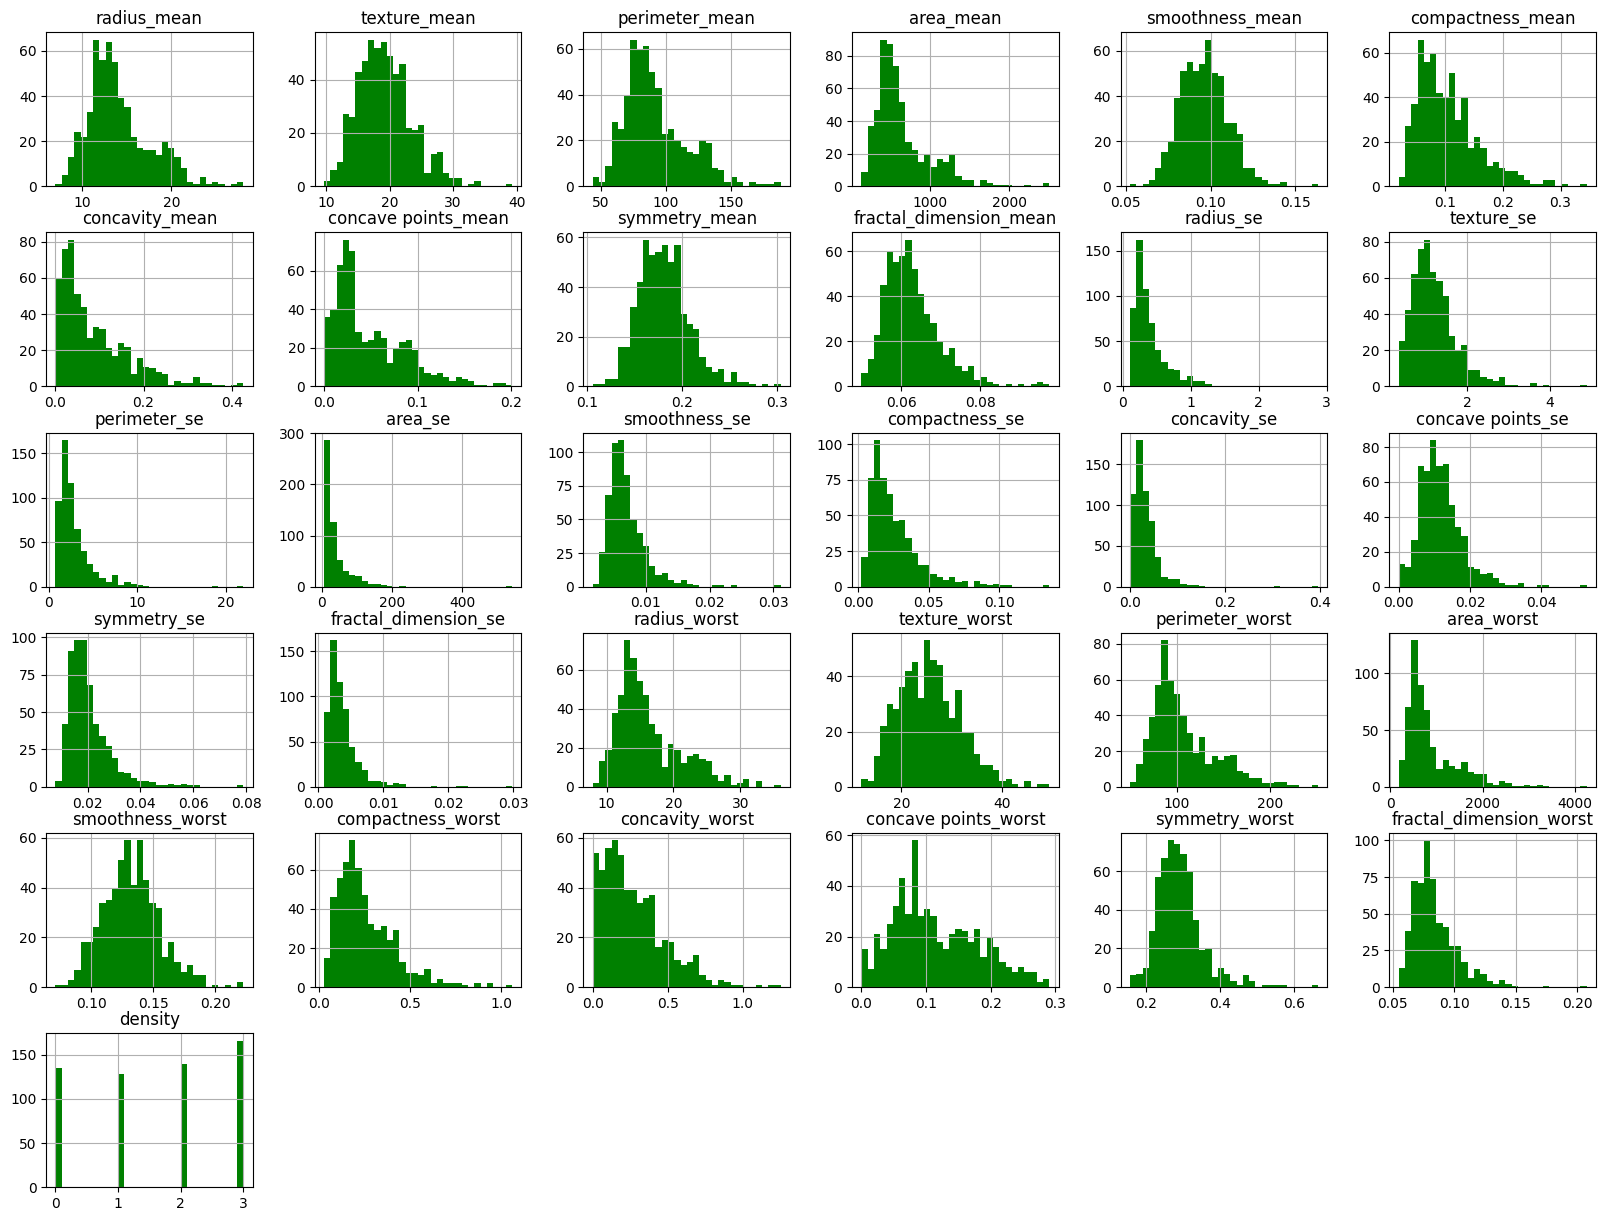

In [ ]:
plt.figure(figsize=(20, 15))
df.hist(bins=30, figsize=(20, 15), color='green') # metoda generiše histogram za svaku numeričku kolonu, broj intervala za histogram je 30, figsize je veličina svih subfigura (subplot-ova) koje će biti kreirane
plt.show()

Na redu je definisanje neuronske mreže. **Neuronska mreža** je vrsta algoritma mašinskog učenja inspirisana radom ljudskog mozga, dizajnirana da prepoznaje uzorke. Osnovni elementi neuronske mreže su neuroni, koji su jedinice za obradu informacija koje primaju ulaze, obrađuju ih i šalju izlaze drugim neuronima.

Epoch [1/20], Loss: 1.3810, Accuracy: 26.1538%
Epoch [2/20], Loss: 1.3297, Accuracy: 48.5714%
Epoch [3/20], Loss: 1.2718, Accuracy: 55.6044%
Epoch [4/20], Loss: 1.1913, Accuracy: 60.0000%
Epoch [5/20], Loss: 1.1012, Accuracy: 61.7582%
Epoch [6/20], Loss: 1.0341, Accuracy: 58.2418%
Epoch [7/20], Loss: 0.8918, Accuracy: 61.7582%
Epoch [8/20], Loss: 0.7758, Accuracy: 64.6154%
Epoch [9/20], Loss: 0.7137, Accuracy: 63.9560%
Epoch [10/20], Loss: 0.6402, Accuracy: 72.0879%
Epoch [11/20], Loss: 0.5674, Accuracy: 83.7363%
Epoch [12/20], Loss: 0.5046, Accuracy: 90.1099%
Epoch [13/20], Loss: 0.4691, Accuracy: 92.7473%
Epoch [14/20], Loss: 0.3922, Accuracy: 96.4835%
Epoch [15/20], Loss: 0.3727, Accuracy: 94.9451%
Epoch [16/20], Loss: 0.3033, Accuracy: 97.5824%
Epoch [17/20], Loss: 0.2672, Accuracy: 98.0220%
Epoch [18/20], Loss: 0.2369, Accuracy: 99.1209%
Epoch [19/20], Loss: 0.2107, Accuracy: 99.3407%
Epoch [20/20], Loss: 0.1809, Accuracy: 99.3407%


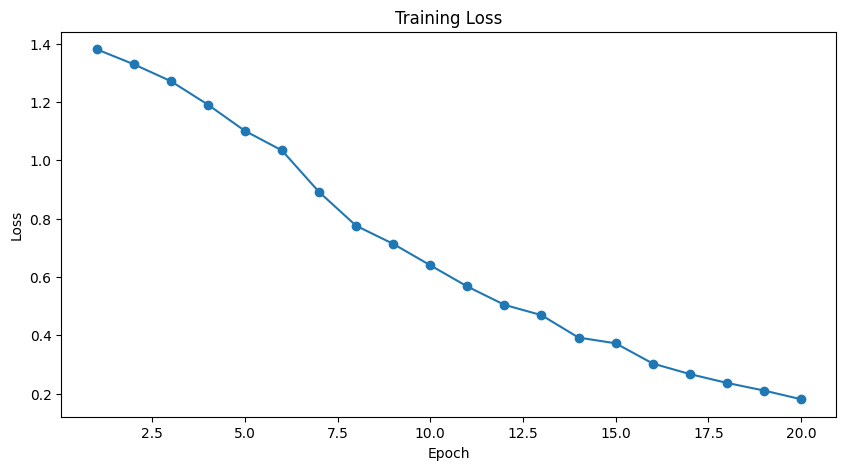

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) # Prvi sloj koji prima input_size ulaza i ima 128 neurona
        self.fc2 = nn.Linear(128, 64) # Drugi sloj sa 128 ulaza i 64 neurona
        self.fc3 = nn.Linear(64, 4) # Treći sloj sa 64 ulaza i 4 izlaza (odgovara broju klasa u ciljnim vrednostima)

    def forward(self, x): # forward metoda: Definiše propagaciju unapred kroz mrežu:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicijalizacija modela, kriterijuma i optimizatora

input_size = X_train.shape[1] # Broj ulaznih karakteristika (kolona) iz trening skupa podataka
model = SimpleNN(input_size)

criterion = nn.CrossEntropyLoss() # Funkcija gubitka (cross-entropy loss) koja se koristi za klasifikaciju
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizator sa početnom stopom učenja od 0.001

num_epochs = 20 # Broj epoha za treniranje
train_losses = [] # Liste za praćenje gubitka i tačnosti tokom treniranja
train_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Određuje da li će se za treniranje koristiti GPU ili CPU
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs) # Propagacija unapred
        loss = criterion(outputs, labels) # Izračunavanje gubitka

        optimizer.zero_grad() # Resetovanje gradijenata
        loss.backward() # Backpropagation
        optimizer.step() # Ažuriranje težina

        running_loss += loss.item() # Ažuriranje ukupnog gubitka
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item() # Ažuriranje broja tačnih predikcija

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%")

plt.figure(figsize=(10, 5)) # Kreiranje i postavljanje veličine figure
plt.plot(range(1, num_epochs + 1), train_losses, marker='o') # Plotovanje gubitka - kreira grafikon gubitka tokom epoha, sa markerima za svaku tačku
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Zatim radimo evaluaciju trenirane neuronske mreže na testnom skupu podataka, izračunavamo i prikazujemo metrike evaluacije kao što su matrica konfuzije (confusion matrix), izveštaj klasifikacije (classification report), i tačnost (accuracy).

Confusion Matrix:
[[24  3  0  0]
 [ 1 23  2  0]
 [ 0  0 28  0]
 [ 0  0  1 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.88      0.88      0.88        26
           2       0.90      1.00      0.95        28
           3       1.00      0.97      0.98        33

    accuracy                           0.94       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Test Accuracy: 93.86%


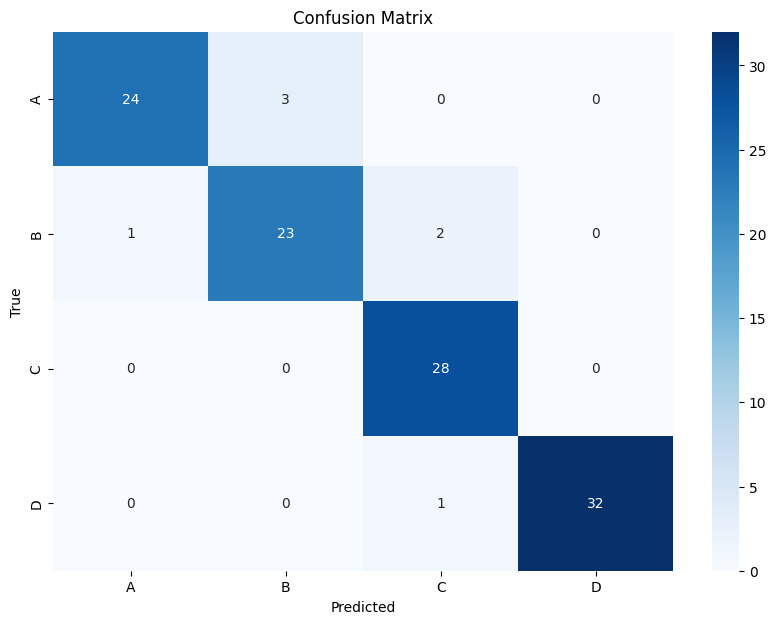

In [ ]:
model.eval()
y_true = []  # Liste za čuvanje stvarnih i predikovanih vrednosti oznaka (labels)
y_pred = []

with torch.no_grad(): # Isključuje računanje gradijenata
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Premesti ulaze i oznake na odgovarajući uređaj
        outputs = model(inputs) # Propagacija unapred
        _, predicted = outputs.max(1) # Predikcija oznaka, gde predicted sadrži indeks klase sa najvećom vrednošću
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy()) # Dodavanje stvarnih i predikovanih oznaka u liste

cm = confusion_matrix(y_true, y_pred) # Izračunava matricu konfuzije koja prikazuje broj tačnih i netačnih predikcija za svaku klasu
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred) # Generiše detaljan izveštaj o performansama klasifikacije, uključujući metrike kao što su preciznost (precision), odziv (recall) i F1-score za svaku klasu
print("Classification Report:")
print(report)

accuracy = accuracy_score(y_true, y_pred) # Izračunava ukupnu tačnost modela, koja predstavlja procenat tačnih predikcija
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(10, 7)) # Kreiranje i postavljanje veličine figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Konačno, generišemo nasumične i stvarne raspodele gustine (density), prikazujemo ih u obliku stubičastih grafikona (count plot), i zatim izračunavamo i vizualizujemo matricu konfuzije između stvarnih i nasumičnih vrednosti gustine.

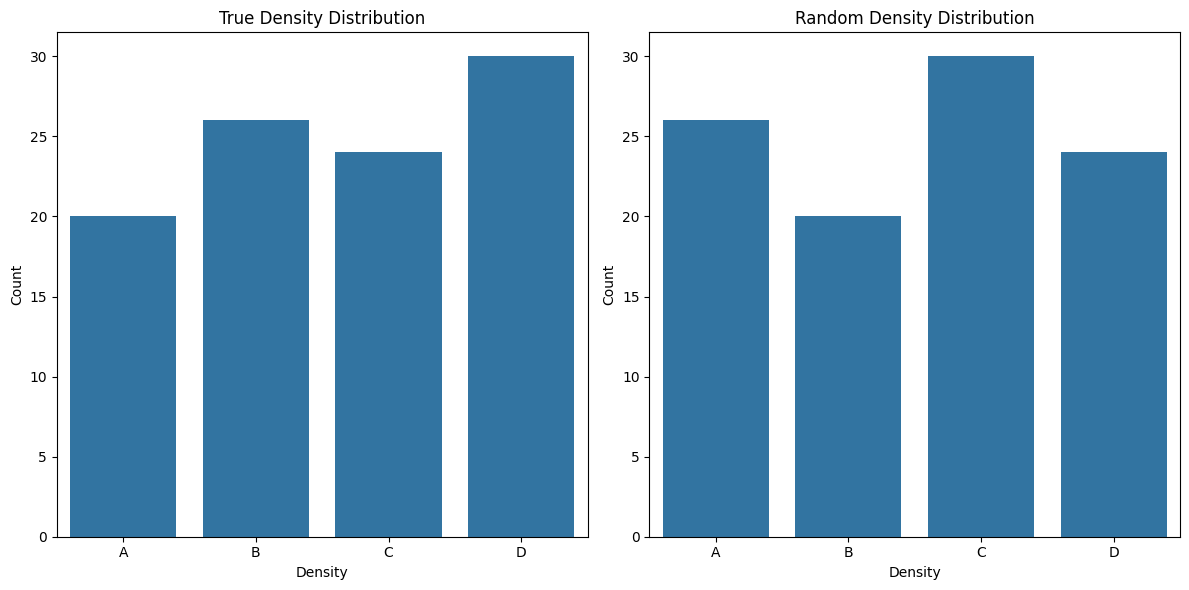

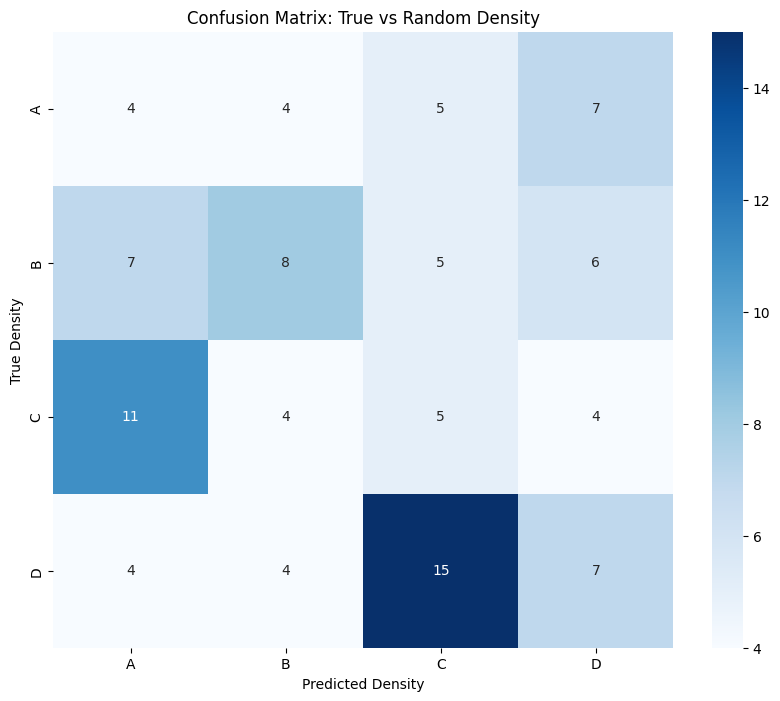

Confusion Matrix:
[[ 4  4  5  7]
 [ 7  8  5  6]
 [11  4  5  4]
 [ 4  4 15  7]]


In [ ]:
np.random.seed(42) # Postavljanje seed-a za generator nasumičnih brojeva kako bi rezultati bili reproducibilni
true_density = np.random.choice(['A', 'B', 'C', 'D'], size=100) # Generisanje niza od 100 nasumičnih vrednosti gustine ('A', 'B', 'C', 'D')

random_density = np.random.choice(['A', 'B', 'C', 'D'], size=100) # Generisanje drugog niza od 100 nasumičnih vrednosti gustine ('A', 'B', 'C', 'D')

plt.figure(figsize=(12, 6)) # Kreiranje i postavljanje veličine figure
plt.subplot(1, 2, 1) # Ovo je prvi subplot u mreži od jednog reda i dve kolone
sns.countplot(x=true_density, order=['A', 'B', 'C', 'D'])
plt.title('True Density Distribution')
plt.xlabel('Density')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=random_density, order=['A', 'B', 'C', 'D'])
plt.title('Random Density Distribution')
plt.xlabel('Density')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_density, random_density, labels=['A', 'B', 'C', 'D'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.xlabel('Predicted Density')
plt.ylabel('True Density')
plt.title('Confusion Matrix: True vs Random Density')
plt.show()

print("Confusion Matrix:")
print(cm)